# Nonlinear dimensionality reduction

## Goals

* Visualize a single-cell dataset with t-SNE, UMAP and PHATE
* Understand how important parameter tuning is to visualization
* Understand how to compare the merits of different dimensionality reduction algorithms

In [ ]:
!pip install scprep phate umap-learn

     |████████████████████████████████| 102kB 3.9MB/s 
     |████████████████████████████████| 419kB 7.1MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 1.8MB 9.8MB/s 


## 1. Loading the Retinal Bipolar dataset

In [ ]:
import scprep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Since we've done the preprocessing on this dataset before, we'll just download the preprocessed data from Google Drive.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene.

In [ ]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [ ]:
data = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

## 2. t-SNE

#### What is tSNE?
t-SNE is the most popular visualization method for single cell RNA-sequencing data. The method was first introduced by Laurens van der Maaten in 2008 in the aptly named article ["Visualizing High-Dimensional Data Using t-SNE"](http://jmlr.org/papers/v9/vandermaaten08a.html). The goal of t-SNE is to produce a two or three dimensional embedding of a dataset that exists in many dimensions such that the embedding can be used for visualization.

By embedding, we're talking about projecting the data from high dimensions onto vectors in a smaller space.

The way t-SNE does this is by minimizing the difference between neighborhood distances (i.e. distances from a cell to a set of close cells) in the original high dimensional space and the lower dimensional embedding space. t-SNE is an optimization problem where the algorithm iteratively learns a series of transformations such that each successive transformation better minimizes this difference between the high and low dimensional neighborhood distances. 

This approach preserves local structure in the data. Cells that are close in high dimensional space (i.e. have small Euclidean distances) will also be close in low dimensional space. However, it also means that global structure will not be preserved. This means that the distance between "clusters" in a t-SNE plot don't have any meaning.


#### How to use t-SNE effectively

Unlike PCA, t-SNE has *hyperparameters* these are user-specified options that determine the output of t-SNE. Having hyperparameters isn't bad, but it is essential to understand what the hyperparameters are, what the effect of hyperpameter choices have on output, and how to select the best set of hyperparameters for a given research objective.

In 2016, a group from Google Brain published great essay in Distill about ["How to Use t-SNE Effectively"](https://distill.pub/2016/misread-tsne/). In the article, they provide an interactive tool to explore the effect of various hyperparameters of t-SNE on various datasets.

There are two main hyperparameters for t-SNE: **perplexity** and **learning rate** (sometimes called epsilon). Perplexity determines the "neighborhood size". Larger values of perplexity increase the number of points within the neighborhood. The reccomended range of t-SNE perplexity is roughly 5-50. Learning rate affects how quickly the algorithm "stablilizes". You probably don't need to change this, but should understand what it is.

This dataset consists of many cell types, which were mostly identified as Amacrine cells, Muller Glia, Rod Bipolar cells, and many subtypes of Cone Bipolar cells in [Shekhar et. al, 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5003425/). We can plot the data using t-SNE, as was done in the original paper.

#### Reducing dimensionality with PCA to speed up t-SNE

t-SNE gets very slow with high-dimensional data. We can speed it up substantially by running PCA first to 100 dimensions.

In [ ]:
data_pca = scprep.reduce.pca(data, n_components=100, method='dense')

#### Subsampling to speed up t-SNE even more

t-SNE is still slow even after PCA, so let's speed things up by using fewer points.

In [ ]:
data_pca_subsample, metadata_subsample = scprep.select.subsample(data_pca, metadata, n=3000)

#### Running t-SNE

tSNE is implemented in `scikit-learn`. t-SNE is a manifold learning algorithm and you can find the t-SNE operator at [`sklearn.manifold.TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

We create a t-SNE operator and run it on data with the following syntax

```python
import sklearn.manifold
tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=30)
data_tsne = tsne_op.fit_transform(data)
```

In [ ]:
import sklearn.manifold
tsne_op = sklearn.manifold.TSNE()
data_tsne = tsne_op.fit_transform(data_pca_subsample)

#### Plotting and interpreting t-SNE

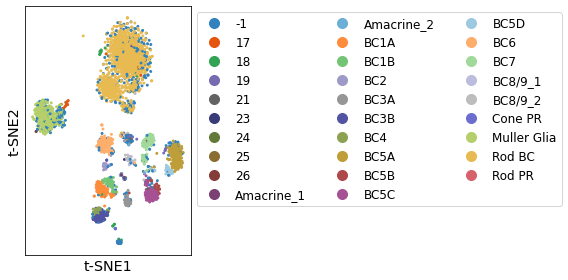

In [ ]:
scprep.plot.scatter2d(data_tsne, c=metadata_subsample['CELLTYPE'],
                      figsize=(8,4), legend_anchor=(1,1),
                      ticks=False, label_prefix='t-SNE')

What do you notice? Is your favorite cell type nicely separated in this plot? How obvious is the distinction between the macro-level cell types of cone bipolar, rod bipolar, and glial cells?

#### Exercise - run t-SNE with different `perplexity` parameters

t-SNE's `perplexity` parameter describes the size of the neighborhood around each point. The authors recommend values between 5 and 100. Try a range of different values in and outside of this range and discuss the results with your group.

*Note: be sure to use `data_pca_subsample`, as t-SNE can take a long time.*

In [ ]:
# ==============
# experiment with the perplexity parameter
tsne_op = sklearn.manifold.TSNE(perplexity=100)
data_tsne = tsne_op.fit_transform(data_pca_subsample)
# ==============

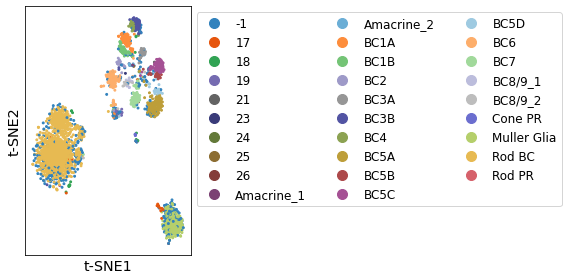

In [ ]:
scprep.plot.scatter2d(data_tsne, c=metadata_subsample['CELLTYPE'],
                      figsize=(8,4), legend_anchor=(1,1), ticks=False, label_prefix='t-SNE')

## 3. UMAP

Even though UMAP is not a part of scikit-learn, the syntax for UMAP is identical to t-SNE: `umap.UMAP().fit_transform`. UMAP is relatively fast, so you won't need to use the subsampled data. We also don't need to do PCA beforehand, but since we've already done it we may as well.

Note, there's an article called ["Understanding UMAP" by Google Research](https://pair-code.github.io/understanding-umap/) that explores the effect of various parameters of UMAP in a similar way to the t-SNE artcile above.

In [ ]:
import umap
umap_op = umap.UMAP()
data_umap = umap_op.fit_transform(data_pca)

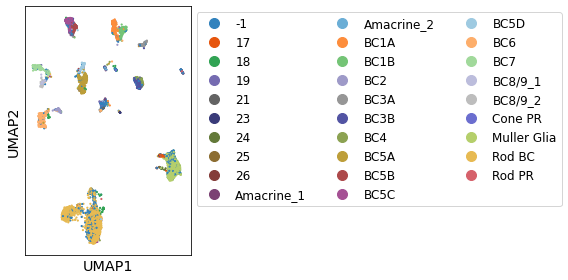

In [ ]:
scprep.plot.scatter2d(data_umap, c=metadata['CELLTYPE'],
                      figsize=(8,4), legend_anchor=(1,1), ticks=False, label_prefix='UMAP')

What do you notice? Is your favorite cell type nicely separated in this plot? How obvious is the distinction between the macro-level cell types of cone bipolar, rod bipolar, and glial cells? How does this plot compare to t-SNE?

### Exercise - run UMAP with different `n_neighbors` and `min_dist` parameters

UMAP's `n_neighbors` parameter describes the size of the neighborhood around each point. The `min_dist` parameter describes how tightly points can be packed together. The authors recommend values between 2 and 200 for `n_neighbors`, and between 0 and 0.99 for `min_dist`. Try a range of different values in and outside of these ranges and discuss the results with your group.

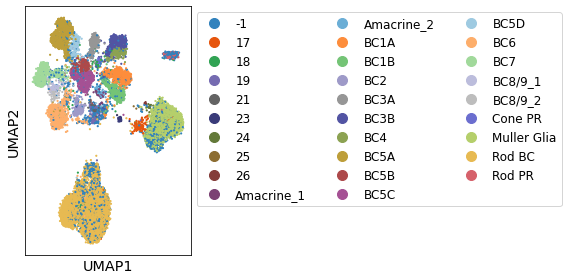

In [ ]:
# ===============
# Choose different values for n_neighbors and min_dist, plotting with scprep
umap_op = umap.UMAP(n_neighbors=50, min_dist=0.8)
data_umap = umap_op.fit_transform(data_pca)
scprep.plot.scatter2d(data_umap, c=metadata['CELLTYPE'],
                      figsize=(8,4), legend_anchor=(1,1), ticks=False, label_prefix='UMAP')
# ===============

## 4. PHATE

### Exercise - perform PHATE and plot the results

The syntax for PHATE is identical to UMAP and t-SNE: `phate.PHATE().fit_transform`. PHATE is relatively fast, so you won't need to use the subsampled data.

In [ ]:
import phate
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data_pca)

Calculating PHATE...
  Running PHATE on 21552 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 116.18 seconds.
    Calculating affinities...
    Calculated affinities in 58.23 seconds.
  Calculated graph and diffusion operator in 174.53 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 7.78 seconds.
    Calculating KMeans...
    Calculated KMeans in 30.11 seconds.
  Calculated landmark operator in 39.72 seconds.
  Calculating optimal t...
    Automatically selected t = 32
  Calculated optimal t in 4.71 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.08 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.51 seconds.
Calculated PHATE in 228.59 seconds.


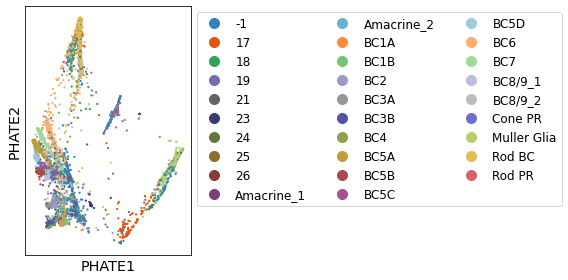

In [ ]:
scprep.plot.scatter2d(data_phate, c=metadata['CELLTYPE'],
                      figsize=(8,4), legend_anchor=(1,1), ticks=False, label_prefix='PHATE')

What do you notice? Is your favorite cell type nicely separated in this plot? How obvious is the distinction between the macro-level cell types of cone bipolar, rod bipolar, and glial cells? How does this plot compare to t-SNE and UMAP?

### Exercise - run PHATE with different `knn` and `t` parameters

PHATE's `knn` parameter describes the size of the neighborhood around each point. The `t` parameter describes how much denoising is performed. We recommend values between 2 and 100 for `n_neighbors`, and between 2 and 150 for `t`. Try a range of different values in and outside of these ranges and discuss the results with your group.

Calculating PHATE...
  Running PHATE on 21552 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 122.28 seconds.
    Calculating affinities...
    Calculated affinities in 56.77 seconds.
  Calculated graph and diffusion operator in 179.17 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 6.11 seconds.
    Calculating KMeans...
    Calculated KMeans in 29.79 seconds.
  Calculated landmark operator in 37.55 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.62 seconds.
Calculated PHATE in 226.67 seconds.


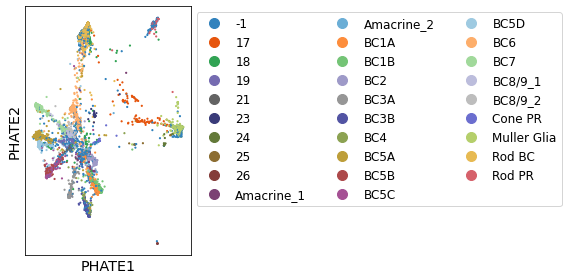

In [ ]:
# ===============
# Choose different values for knn and y, plotting with scprep
phate_op = phate.PHATE(knn=3, t=40, gamma=0)
data_phate = phate_op.fit_transform(data_pca)
scprep.plot.scatter2d(data_phate, c=metadata['CELLTYPE'],
                      figsize=(8, 4), legend_anchor=(1, 1), ticks=False, label_prefix='PHATE')
# ===============

### Discussion 

In groups, discuss the following questions:
1. In a dataset with clusters, how well does each method perform?
- t-SNE and UMAP perform particularly well on clustered data. PHATE does okay, but sometimes shows connections between the clusters.

2. How might you determine which method is closest to the ground truth?
- generate simulated data with known ground truth and compare this to the visualizations

3. Which parameters are the most similar between methods?
- knn/perplexity is shared across all of the different methods, and in each case determines the neighborhood size

4. Which method is the most / least sensitive to parameter selection?
- depends on the parameter

5. If you run the same method with the same parameters multiple times, do you always get the same result?
- t-SNE: definitely not, UMAP:sometimes, PHATE: yes